In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.utils import plot_model


from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca
from lob_data_utils.svm_calculation import lob_svm
from numpy.random import seed
seed(1)


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 15000
stock = '9064'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1), (0.01, 0.1)]

In [3]:
df_log = pd.read_csv('../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc
10,0.081063,0.5403,0.071621,0.53506,0.081458,0.540529


In [4]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

In [5]:
df = gdf_dfs[1].df
df_test = gdf_dfs[1].df_test

In [6]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
import tensorflow as tf
auc_roc = as_keras_metric(tf.metrics.auc)

In [78]:
X_train = df[[gdf for gdf in gdf_dfs[0].df.columns if 'gdf' in gdf or 'queue' in gdf]].values

pca = PCA(n_components=10)
pca.fit(X_train)
X_train = pca.transform(X_train)


print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 10))
print(X_train.shape, X_train[0])
y_train = df['mid_price_indicator'].values
from keras.utils import to_categorical
print(y_train)
y_train = to_categorical(y_train)
print(y_train)

(11999, 10)
(11999, 1, 10) [[ 8.03684455e-01 -2.59166263e-01 -2.18981194e-03 -2.49577730e-04
   1.04311335e-02  1.04069174e-02 -1.56815275e-02  5.21206073e-03
  -1.10669100e-03 -7.05417722e-03]]
[0. 1. 1. ... 0. 0. 0.]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


{'loss': [0.689071329298273, 0.6883888926215147, 0.6883914086140934, 0.6878309954662245, 0.6880568823761538, 0.688084092360952, 0.6878105874498325, 0.6877971552781179, 0.68785172924418, 0.6879226406004659, 0.6878155153963464, 0.6876118149605579, 0.6873872626403023, 0.6876632590941245, 0.6874724281798881, 0.6873438655262103, 0.6874315168313339, 0.687352978186723, 0.6873102694891405, 0.6873236922971785, 0.6873138741519373, 0.6871779839668049, 0.6872510164615978, 0.6874507802040818, 0.687233687684043, 0.6873090182833795, 0.6872264728495275, 0.687124679670581, 0.6870316781345154, 0.6872873129829962, 0.6871778174622554, 0.6872164496819927, 0.6872837636379194, 0.6872933700994925, 0.6873130588861731, 0.6872057584049562, 0.6871552908904394, 0.6872885963282731, 0.6871687267331126, 0.6873407937783144, 0.6871154019808569, 0.6870949649842583, 0.6871844886372374, 0.6871048551627482, 0.6868308582686615, 0.6871133061963048, 0.687415543253476, 0.6871691478005111, 0.6872105705747009, 0.687060109738837]

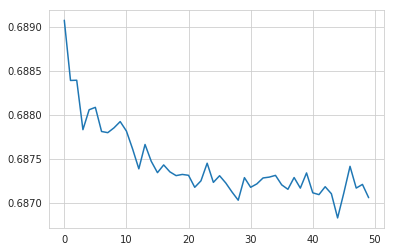

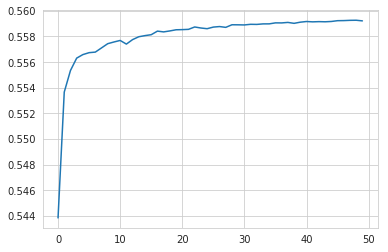

In [80]:
def train_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

    model.fit(X_train, y_train, epochs=3, batch_size=10)
    plot_model(model, to_file='model0.png', show_shapes=True, show_layer_names=True)
    print(model.summary())

    return model

def train_model1(X_train, y_train):
    model = Sequential()
    model.add(LSTM(128, input_shape=(1, 10)))
    model.add(Dense(128, input_shape=(128, 1), activation='tanh'))
  #  model.add(Dropout(0.1, input_shape=(128, 1)))
    model.add(Dense(2, input_shape=(128, 1), activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[auc_roc])
    history = model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
    print(history.history)
    plt.plot(history.history['loss'])
    plt.figure()
    plt.plot(history.history['auc'])
    print(model.summary())
    print(model.evaluate(X_train, y_train))
    plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)
    return model
model = train_model1(X_train, y_train)

In [93]:
X_test = df_test[[gdf for gdf in gdf_dfs[1].df_test.columns if 'gdf' in gdf or 'queue' in gdf]].values

X_test = pca.transform(X_test)


print(X_test.shape)
X_test= np.reshape(X_test, (X_test.shape[0], 1, 10))
y_test = df_test['mid_price_indicator'].values

(2999, 10)


In [99]:
pred_test = model.predict_classes(X_test)
pred = model.predict_classes(X_train)

#pred = [np.argmax(p) for p in pred]
#pred_test = [np.argmax(p) for p in pred_test]

from sklearn import metrics
metrics.roc_auc_score(y_test, pred_test), metrics.roc_auc_score([np.argmax(y) for y in y_train], pred)

(0.5553099077408202, 0.5469030537483247)

In [101]:
metrics.matthews_corrcoef(y_test, pred_test), metrics.matthews_corrcoef([np.argmax(y) for y in y_train], pred)

(0.11117140316757734, 0.093858084679031)